In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import matplotlib.pyplot as plt
from copy import copy

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.dynamics.discrete_time_systems import LinearSystem, AffineSystem, PieceWiseAffineSystem
from pympc.control.hybrid_benchmark.controllers import HybridModelPredictiveController
from pympc.plot import plot_input_sequence, plot_state_trajectory, plot_output_trajectory
from pympc.control.hybrid_benchmark.utils import get_constraint_set, remove_redundant_inequalities_fast, convex_hull_method_fast

In [2]:
m = 1.
k = 100.
c = 5.
g = 10.
h = .02

In [3]:
# discretization method
method = 'zero_order_hold'

# dynamics n.1 (ball in the air)
A1 = np.array([
    [0., 0., 1.],
    [0., 0., 0.],
    [0., 0., 0.]
    ])
B1 = np.array([
    [0.],
    [1.],
    [0.]
    ])
c1 = np.array([
    [0.],
    [0.],
    [-g]
    ])
S1 = AffineSystem.from_continuous(A1, B1, c1, h, method)

# dynamics n.2 (paddle pulling ball)
S2 = copy(S1)

# dynamics n.1 (paddle pushing ball)
# (no offset terms, the zero of the position of the ball is shifted by m*g/k)
A3 = np.array([
    [0., 0., 1.],
    [0., 0., 0.],
    [-k/m, k/m, -c/m]
    ])
B3 = np.array([
    [0.],
    [1.],
    [c/m]
    ])
S3 = LinearSystem.from_continuous(A3, B3, h, method)

# list of dynamics
S_list = [S1, S2, S3]

In [4]:
# state bounds
x_max = np.array([
    [1.],
    [.1],
    [4.]
])
x_min = np.array([
    [-.3],
    [-.1],
    [-4.]
])
f_max = 4.*m*g


# input bounds
u_max = np.array([[.3]])
u_min = - u_max

# domain bounds
xu_min = np.vstack((x_min, u_min))
xu_max = np.vstack((x_max, u_max))

# domain n.1
# (out of contact when q_ball - q_paddle > m*g/k)
D1 = Polyhedron.from_bounds(xu_min, xu_max)
D1.add_inequality(
    np.array([[-1., 1., 0., 0.]]),
    np.array([[-m*g/k]])
)
assert D1.bounded
assert not D1.empty

# domain n.2
# (pulling when q_ball - q_paddle < m*g/k
# and f = k (qp - qb) + c (qpd - qbd) + m g < 0)
D2 = Polyhedron.from_bounds(xu_min, xu_max)
D2.add_inequality(
    np.array([[1., -1., 0., 0.]]),
    np.array([[m*g/k]])
)
D2.add_inequality(
    np.array([[-k, k, -c, c]]),
    np.array([[-m*g]])
)
assert D2.bounded
assert not D2.empty

# domain n.3
D3 = Polyhedron.from_bounds(xu_min, xu_max)
D3.add_inequality( # penetration > 0
    np.array([[1., -1., 0., 0.]]),
    np.array([[m*g/k]])
)
D3.add_inequality( # not pulling
    np.array([[k, -k, c, -c]]),
    np.array([[m*g]])
)
D3.add_inequality( # maximum force < 5 m g
    np.array([[-k, k, -c, c]]),
    np.array([[f_max - m*g]])
)
assert D3.bounded
assert not D3.empty

# list of domains
D_list = [D1, D2, D3]

In [5]:
S = PieceWiseAffineSystem(S_list, D_list)

In [6]:
# controller parameters
N = 80
Q = np.diag([5.,50.,.1])
R = np.diag([10.])

# terminal set and cost
P = Q
X_N = Polyhedron.from_bounds(np.zeros((3,1)),np.zeros((3,1)))
# P, K = S3.solve_dare(Q, R)
# X_N = S3.mcais(K, D3, verbose=True)
# X_N = Polyhedron.from_bounds(x_min, x_max)
# X_N.add_lower_bound(np.array([[1.]]),[0])
# P = Q

controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, 'Multiple big-Ms')

x0 = np.array([[1.], [.0], [.0]])
u_mip, x_mip, ms_mip, cost_mip = controller.feedforward(x0)

In [ ]:
x0 = np.array([[1.], [.0], [.0]])
methods = [
#     'Traditional formulation',
#     'Big-M',
#     'Convex hull',
    'Convex hull, lifted constraints'
]
solves = {}
for method in methods:
    print method
    controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method)
    controller.prog.setParam('OutputFlag', 0)
#     controller.prog.setParam('TimeLimit', 6000)
#     controller.prog.setParam('Heuristics', 0)
#     controller.prog.setParam('MIPFocus', 0)
    u_mip, x_mip, ms_mip, cost_mip = controller.feedforward(x0)
    print controller.prog.objVal
    solves[method] = {
        'time': controller.prog.Runtime,
        'nodes': controller.prog.NodeCount
    }
    print controller.prog.Runtime, controller.prog.NodeCount

In [ ]:
for method in methods:
    print method
    print 'Solution time:', solves[method]['time']
    print 'Explored nodes:', solves[method]['nodes']

In [ ]:
plt.rc('font', size=22)

# input
plot_input_sequence(u_mip, h, (u_min, u_max), legend=False)
plt.savefig('input.pdf',bbox_inches='tight')
plt.show()

# state
plot_state_trajectory(x_mip, h, (x_min, x_max), legend=False)
plt.savefig('state.pdf',bbox_inches='tight')
plt.show()

# output (contcat force)
f = [k*(x_mip[t][1]-x_mip[t][0]) + c*(u_mip[t][0]-x_mip[t][2]) + m*g for t in range(N)]
for t in range(N):
    if ms_mip[t] != 2:
        f[t] = 0.
f = [f[0]] + f
plt.step(range(N+1), f, color='b')
plt.step(range(N+1), [f_max]*(N+1), color='r')
plt.step(range(N+1), [0.]*(N+1), color='r')
plt.xlabel(r'$t$')
plt.ylabel(r'$f \ (x,u)$')
plt.xlim((0., N))
plt.savefig('force.pdf',bbox_inches='tight')
plt.show()

In [ ]:
costs = {}
methods = [
    'Traditional formulation',
    'Big-M',
    'Convex hull',
    'Convex hull, lifted constraints'
]
for method in methods:
    print method
    controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method)
    costs[method] = []
    for ms in [ms_mip[:i] for i in range(N+1)]:
        cost = controller.feedforward_relaxation(x0, ms)[3]
        if cost is not None:
            cost /= cost_mip
        costs[method].append(cost)

In [ ]:
plt.rc('font', size=12)
for method in methods:
    plt.plot(range(N+1), costs[method], label=method)
plt.xlim((0, N))
plt.ylim((0, 1.1))
plt.legend()
plt.grid()
plt.xlabel(r'$t$')
plt.ylabel(r'Cost relaxed problem / cost MICP')
plt.savefig('relaxation_ratio.pdf',bbox_inches='tight')

plt.plot(h*np.array(range(N+1)),[xt[0] for xt in x_mip], label='ball')
plt.plot(h*np.array(range(N+1)),[xt[1] for xt in x_mip], label='paddle')
plt.legend()

In [ ]:
methods = [
    'Traditional formulation',
    'Big-M',
    'Convex hull',
    'Convex hull, lifted constraints'
]
q_p = 0.
n_samples = 101
q_b_samples = np.linspace(x_min[0], x_max[0], n_samples)
v_b_samples = np.linspace(x_min[2], x_max[2], n_samples)
for method in methods:
    print method
    controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method)
    if method in ['Traditional formulation', 'Big-M', 'Convex hull']:
        cs = get_constraint_set(controller.prog)
        var_indices = {v: i for i, v in enumerate(controller.prog.getVars())}
        v_index = var_indices[controller.prog.getVarByName('x0[1]')]
        A_sect = np.hstack((cs.A[:, :v_index], cs.A[:, v_index+1:]))
        b_sect = cs.b - cs.A[:, v_index:v_index+1] * q_p
        cs_sect = Polyhedron(A_sect, b_sect)
        sect = convex_hull_method_fast(cs_sect, [0,1])
    cost_mat = np.empty([n_samples]*2)
    for i, q_b in enumerate(q_b_samples):
        for j, v_b in enumerate(v_b_samples):
            print(str(i) + ',' + str(j) + '   \r'),
            x0 = np.array([[q_b],[q_p],[v_b]])
            cost = controller.feedforward_relaxation(x0, [])[3]
            cost_mat[i,j] = cost
    Q_b, V_b = np.meshgrid(q_b_samples, v_b_samples)
    cp = plt.contour(Q_b, V_b, cost_mat.T)
    plt.colorbar(cp, label='Cost relaxed problem')
    sect.plot(facecolor='w')
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_3$')
    plt.title(method)
    np.save(method + '_feasible_set_A', sect.A)
    np.save(method + '_feasible_set_b', sect.b)
    np.save(method, cost_mat)
    plt.savefig(method + '.pdf',bbox_inches='tight')
    plt.show()

In [ ]:
methods = [
    'Traditional formulation',
    'Big-M',
    'Convex hull',
    'Convex hull, lifted constraints'
]
for method in methods:
    cost_mat = np.load(method + '.npy')
    if method in ['Traditional formulation', 'Big-M', 'Convex hull']:
        A = np.load(method + '_feasible_set_A.npy')
        b = np.load(method + '_feasible_set_b.npy')
        sect = Polyhedron(A, b)
    n_levels = 10
    print np.nanmax(cost_mat)
    levels = [my_round((i+1)*np.nanmax(cost_mat)/n_levels) for i in range(n_levels)]
    cp = plt.contour(Q_b, V_b, cost_mat.T, levels=levels)
    plt.colorbar(cp, label='Cost relaxed problem')
    sect.plot(facecolor='w')#, label='Feasible set section')
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_3$')
    plt.title(method)
    plt.grid(True)
    plt.savefig(method + '.pdf',bbox_inches='tight')
    plt.show()

In [ ]:
### COMMENT prog.reset() BEFORE RUNNING THIS!!!

q_p = 0.
n_samples = 101
cost_mat = np.empty([n_samples]*2)
q_b_samples = np.linspace(x_min[0], x_max[0], n_samples)
v_b_samples = np.linspace(x_min[2], x_max[2], n_samples)
controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, 'Big-M')
controller.prog.setParam('OutputFlag', 0)
controller.prog.setParam('MIPGap', 0.01)
controller.prog.setParam('TimeLimit', 1200.)
time_limits = 0
for i, q_b in enumerate(q_b_samples):
    for j, v_b in enumerate(v_b_samples):
        print(str(i) + ',' + str(j) + ',' + str(time_limits) + '    \r'),
        x0 = np.array([[q_b],[q_p],[v_b]])
        cost = controller.feedforward(x0)[3]
        cost_mat[i,j] = cost
        if controller.prog.status == 9:
            time_limits += 1
Q_b, V_b = np.meshgrid(q_b_samples, v_b_samples)
cp = plt.contourf(Q_b, V_b, cost_mat.T)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_3$')
plt.colorbar(cp, label='Cost MICP')

np.save('q_b_samples', q_b_samples)
np.save('v_b_samples', v_b_samples)
np.save('cost_mat_miqp', cost_mat)

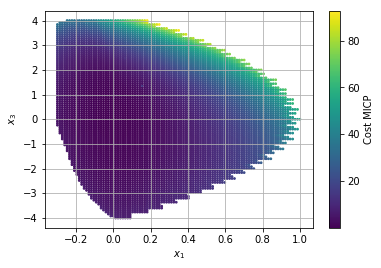

92.84113390506361


In [33]:
plt.figure()
cost_mat = np.load('cost_mat_miqp.npy')
cost_mat = fill_holes_cost_mat(cost_mat)
n_samples = 101
q_b_samples = np.linspace(x_min[0], x_max[0], n_samples)
v_b_samples = np.linspace(x_min[2], x_max[2], n_samples)
x = q_b_samples.tolist() * v_b_samples.size
y = [v_b for v_b in v_b_samples for i in q_b_samples]
plt.scatter(x, y, c=cost_mat.T.flatten(), s=3.)
plt.colorbar(label='Cost MICP')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_3$')
plt.grid(True)
# plt.savefig('cost_mat_miqp_scatter.pdf',bbox_inches='tight')
plt.show()
print np.nanmax(cost_mat)

92.84113390506361


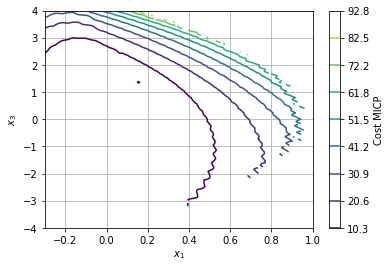

In [34]:
cost_mat = np.load('cost_mat_miqp.npy')
cost_mat = fill_holes_cost_mat(cost_mat)
print np.nanmax(cost_mat_new)

Q_b, V_b = np.meshgrid(q_b_samples, v_b_samples)
n_levels = 9
levels = [0.] + [my_round((i+1)*np.nanmax(cost_mat)/n_levels) for i in range(n_levels)]
cp = plt.contourf(Q_b, V_b, cost_mat.T, levels=levels)#, cmap='Purples')
plt.grid(True)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_3$')
plt.colorbar(cp, label='Cost MICP')
plt.grid(True)
plt.savefig('cost_mat_miqp.pdf',bbox_inches='tight')

In [17]:
from math import floor

def my_round(x):
    return floor(x*10.)/10.

def fill_holes_cost_mat(cost_mat):
    for i in range(1,n_samples-1):
        for j in range(1,n_samples-1):
            if np.isnan(cost_mat[i,j]):
                neighbors = [
                    cost_mat[i+1,j-1],
                    cost_mat[i+1,j],
                    cost_mat[i+1,j+1],
                    cost_mat[i,j+1],
                    cost_mat[i-1,j+1],
                    cost_mat[i-1,j],
                    cost_mat[i-1,j-1],
                    cost_mat[i,j-1]
                ]
                if not any([np.isnan(n) for n in neighbors]):
                    cost_mat[i,j] = sum(neighbors)/8.
    return cost_mat

In [ ]:
cp = plt.contourf(Q_b, V_b, cost_mat.T)#,cmap=plt.cm.terrain)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_3$')
plt.colorbar(cp, label='MICP objective')
# plt.savefig('objective_miqp' + '.pdf',bbox_inches='tight')